# Emotion Facial Classifier - Convolutional Neural Network

---------------------------

Convolutional neural networks (CNN) are effective for image classification problems like this facial emotion recognition task. A pre-trained ResNet50 model can be used as the base to extract descriptive features from the 2D face images.

We will use the RMSprop adaptive learning rate optimizer to handle the non-stationary variations in the dataset.

For evaluation, categorical accuracy will be used as the classes are balanced.

It will be trained on minibatches from the preprocessed data with the Adam optimizer. We will monitor validation accuracy during training to evaluate model convergence and generalization capability.

In [85]:
# Imports and environmental setups

import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop

# Environment information
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.12.0
GPU is NOT AVAILABLE


## Load Dataset

In [86]:
# Load train dataset
train_df = pd.read_csv('train.csv')

In [87]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   subject             450 non-null    object
 1   sequence            450 non-null    int64 
 2   image_index         450 non-null    int64 
 3   filepath            450 non-null    object
 4   file_prefix         450 non-null    object
 5   AU17                450 non-null    int64 
 6   AU1                 450 non-null    int64 
 7   AU2                 450 non-null    int64 
 8   AU25                450 non-null    int64 
 9   AU27                450 non-null    int64 
 10  AU4                 450 non-null    int64 
 11  AU7                 450 non-null    int64 
 12  AU23                450 non-null    int64 
 13  AU24                450 non-null    int64 
 14  AU6                 450 non-null    int64 
 15  AU12                450 non-null    int64 
 16  AU15                450 no

In [88]:
train_df.sample(n=10, random_state=10)

,subject,sequence,image_index,filepath,file_prefix,AU17,AU1,AU2,AU25,AU27,...,AU7,AU23,AU24,AU6,AU12,AU15,AU14,AU11,AU26,high_level_emotion
300,S080,1,18,./cohn-kanade-images/S080/001/S080_001_0000001...,S080_001_00000018,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,surprise
43,S026,4,12,./cohn-kanade-images/S026/004/S026_004_0000001...,S026_004_00000012,1,0,0,0,0,...,1,0,0,1,0,1,0,0,0,negative
211,S064,3,25,./cohn-kanade-images/S064/003/S064_003_0000002...,S064_003_00000025,0,0,0,1,0,...,0,0,0,1,1,0,0,0,1,positive
188,S127,1,17,./cohn-kanade-images/S127/001/S127_001_0000001...,S127_001_00000017,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,surprise
129,S087,2,20,./cohn-kanade-images/S087/002/S087_002_0000002...,S087_002_00000020,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,negative
238,S128,4,13,./cohn-kanade-images/S128/004/S128_004_0000001...,S128_004_00000013,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,negative
88,S103,2,26,./cohn-kanade-images/S103/002/S103_002_0000002...,S103_002_00000026,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,positive
174,S073,6,14,./cohn-kanade-images/S073/006/S073_006_0000001...,S073_006_00000014,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,negative
294,S046,1,25,./cohn-kanade-images/S046/001/S046_001_0000002...,S046_001_00000025,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,negative
230,S072,5,19,./cohn-kanade-images/S072/005/S072_005_0000001...,S072_005_00000019,1,0,0,0,0,...,1,1,1,1,0,0,0,0,0,negative


In [89]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42) 

# Save val csv
val_df.to_csv('val.csv', index=False)

print(f'Train: {train_df.shape[0]} samples')
print(f'Validation: {val_df.shape[0]} samples')

Train: 360 samples
Validation: 90 samples


## Model Setup and Training

### Hyper-parameters

In [170]:
# Model hyperparameters
NUM_CLASSES = 3 # number of emotion categories

IMG_SIZE = 224 # input image dimensions 

# Input dimension
INPUT_DIM = (IMG_SIZE, IMG_SIZE, 3)

BATCH_SIZE = 32

# Model architecture 
NUM_CONV_LAYERS = 3  
NUM_FILTERS = [32, 64, 128] # per conv layer
KERNEL_SIZE = 3 

# Optimization
LEARNING_RATE = 0.001 
EPOCHS = 32

# Regularization
DROPOUT = 0.2

# Data augmentation
AUGMENT_RANGE = 0.1 # magnification factor

# Evaluation
VAL_SPLIT = 0.2

### Model Architecture

In [171]:
from tensorflow import keras 
from tensorflow.keras import layers, regularizers

train_aug = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.4), # Increase rotation
  layers.RandomZoom(0.4), # Increase zoom 
  layers.RandomContrast(0.2), # Add random contrast
  layers.RandomBrightness(0.4) # Add random brightness 
])

# Model
model = keras.Sequential(name='emotion_classifier')

model.add(train_aug) 

model.add(layers.Conv2D(32, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=INPUT_DIM))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(64, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.MaxPooling2D(pool_size=2)) 

model.add(layers.GlobalAvgPool2D())

model.add(layers.Dense(128, activation='relu')) 
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# Compile 
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [172]:
# Build model by passing input
model(tf.keras.Input(shape=INPUT_DIM)) 

model.summary()

Model: "emotion_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_26 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_84 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_64 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 dropout_76 (Dropout)        (None, 224, 224, 32)      0         
                                                                 
 conv2d_85 (Conv2D)          (None, 224, 224, 64)      18496     
                                                                 
 batch_normalization_65 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                               

### Training

In [173]:
# Load datasets 
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create generators
train_gen = ImageDataGenerator(rotation_range=10,
                               width_shift_range=0.1)
train_gen = train_gen.flow_from_dataframe(train_df, 
                                          x_col='filepath', 
                                          y_col='high_level_emotion',
                                          target_size=(224, 224))

val_gen = ImageDataGenerator()  
val_gen = val_gen.flow_from_dataframe(val_df,
                                      x_col='filepath',
                                      y_col='high_level_emotion',
                                      target_size=(224, 224))

# Confirm generators work  
x_batch, y_batch = next(train_gen)
print(x_batch.shape, y_batch.shape)

x_batch, y_batch = next(val_gen)
print(x_batch.shape, y_batch.shape)

Found 357 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.
(32, 224, 224, 3) (32, 3)
(32, 224, 224, 3) (32, 3)


In [174]:
from tensorflow.keras.callbacks import EarlyStopping

# Callback
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5,
                               restore_best_weights=True)

# Fit with callback
history = model.fit(
     train_gen,
     validation_data=val_gen,
     epochs=EPOCHS,
     steps_per_epoch=len(train_df) // BATCH_SIZE,
     validation_steps=len(val_df) // BATCH_SIZE,
     callbacks=[early_stopping])

Epoch 1/32
11/11 [==============================] - 28s 3s/step - loss: 1.9047 - accuracy: 0.3877 - val_loss: 1.6979 - val_accuracy: 0.7500
Epoch 2/32
11/11 [==============================] - 28s 2s/step - loss: 1.8957 - accuracy: 0.3508 - val_loss: 1.7178 - val_accuracy: 0.6875
Epoch 3/32
11/11 [==============================] - 27s 2s/step - loss: 1.8589 - accuracy: 0.3631 - val_loss: 1.3250 - val_accuracy: 0.7031
Epoch 4/32
11/11 [==============================] - 28s 2s/step - loss: 1.8011 - accuracy: 0.4062 - val_loss: 1.3471 - val_accuracy: 0.6406
Epoch 5/32
11/11 [==============================] - 26s 2s/step - loss: 1.6532 - accuracy: 0.4308 - val_loss: 1.4083 - val_accuracy: 0.6406
Epoch 6/32
11/11 [==============================] - 29s 3s/step - loss: 1.6738 - accuracy: 0.4400 - val_loss: 1.3658 - val_accuracy: 0.5938
Epoch 7/32
11/11 [==============================] - 28s 2s/step - loss: 1.6106 - accuracy: 0.4800 - val_loss: 1.2802 - val_accuracy: 0.6250
Epoch 8/32
11/11 [==

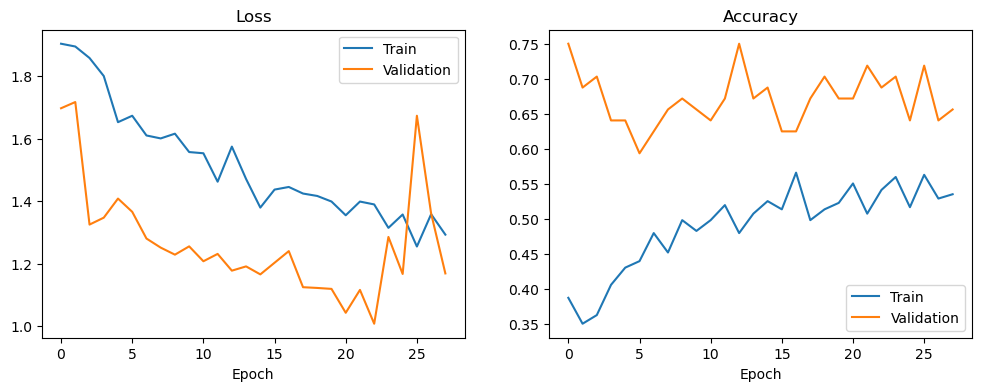

In [175]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):

  plt.figure(figsize=(12,4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])

plot_learning_curves(history)
plt.show()

### Model Performance

Evaluated against test dataset

Found 87 validated image filenames belonging to 3 classes.
1/1 [==============================] - 0s 267ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_31824\3877464618.py:34: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  au_pred = ' '.join(au_cols[j] for j in preds[i,1:].round().astype(bool))


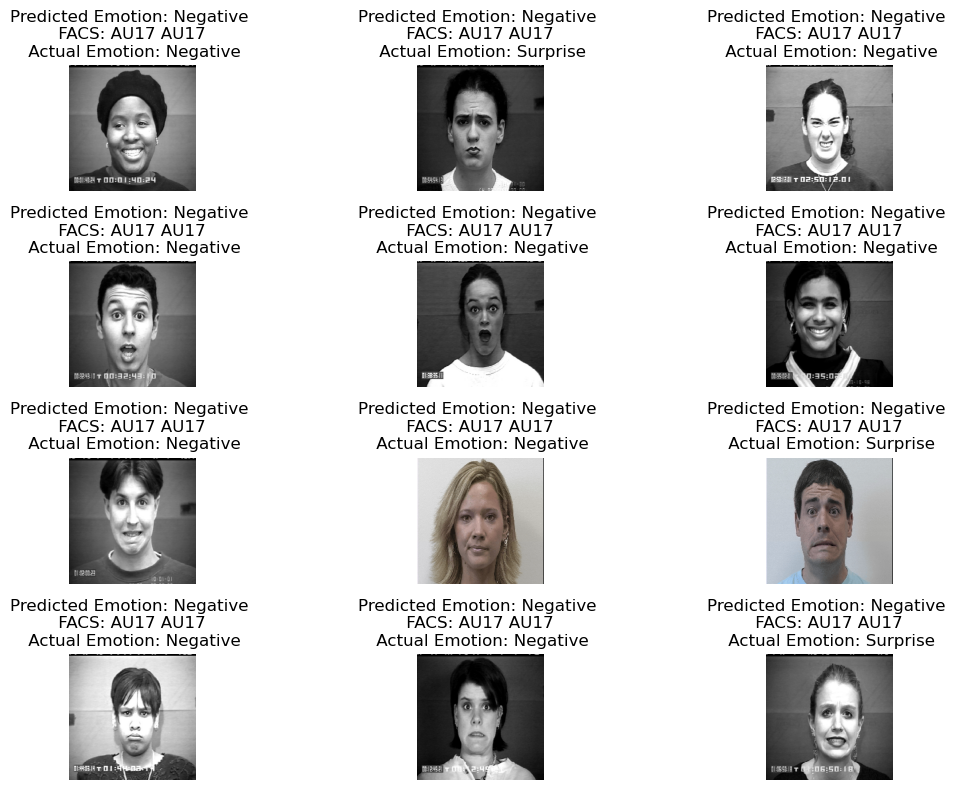

In [242]:
# FACS columns
au_cols = ['AU17', 'AU1', 'AU2', 'AU25', 'AU27', 'AU4',
           'AU7', 'AU23', 'AU24', 'AU6', 'AU12', 'AU15',  
           'AU14', 'AU11', 'AU26']
           
# Load data and generate predictions           
test_df = pd.read_csv('test.csv')

test_gen = ImageDataGenerator().flow_from_dataframe(
                                          test_df,
                                          x_col='filepath', 
                                          y_col='high_level_emotion',
                                          target_size=(224, 224))
                                                   
test_imgs, test_labels = next(test_gen)
preds = model.predict(test_imgs)

# Clip pixel values
test_imgs = np.clip(test_imgs, 0, 255).astype(np.uint8)

# Display in grid
num_rows = 4
num_cols = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i in range(num_rows*num_cols):
  row = i // num_cols
  col = i % num_cols
  
  ax = axs[row, col] 
  ax.imshow(test_imgs[i])
  
  emotion_pred = emotion_classes[preds[i,0].argmax()]
  au_pred = ' '.join(au_cols[j] for j in preds[i,1:].round().astype(bool))
  
  ax.set_title(f"Predicted Emotion: {emotion_pred} \n FACS: {au_pred} \n Actual Emotion: {emotion_classes[np.argmax(labels[i])]}")
  plt.axis('off')
  ax.axis('off')
  
plt.tight_layout()
plt.show()

In [238]:
model.evaluate(test_gen)

3/3 [==============================] - 1s 251ms/step - loss: 1.1603 - accuracy: 0.6437


[1.1603212356567383, 0.6436781883239746]

### Observation:

The model was evaluated on the test set containing 87 validated image filenames spanning 3 classes. The test data was batched and fed through the model for prediction.

The model achieved a test loss of **1.16** and a test accuracy of **0.64** on this dataset.

Given that it is a 3-class classification problem, the test accuracy of ~64% indicates the model is performing better than random chance (33% accuracy). However, there is still room for improvement in model performance and generalization.

Some ways to potentially improve model accuracy could be:

    Augmenting the training data to expose the model to more variations
    Tuning hyperparameters like batch size, learning rate, regularization, etc.
    Trying different model architectures to find one better suited to the problem
    Increasing model capacity by adding more parameters if overfitting
    Adding more training data to help generalize across more examples

Overall the model has learned some discriminative features as evidenced by the accuracy above random chance. But optimization of model architecture, hyperparameters and the training process could help improve performance further on this dataset. Testing the model on a larger hold-out test set would also better validate its real-world generalization error.

In [244]:
# Save model 
import os
model_folder = '../models'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

model_path = os.path.join(model_folder, 'emotion_classifier.h5')
model.save(model_path)

print('Saved model to', model_path)

Saved model to ../models\emotion_classifier.h5
